In [0]:
# CELLULE 1 — Imports
from pyspark.sql import functions as F
from pyspark.sql.types import *

print("Imports OK")

Imports OK


In [0]:
# ============================================================
# CELLULE 2 — Chargement du dataset Steam depuis Unity Catalog
# ============================================================
df_raw = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", '"') \
    .csv("/Volumes/workspace/default/steam/steam.csv")

print(f"Dataset chargé !")
print(f"Nombre de jeux : {df_raw.count()}")
print(f"Nombre de colonnes : {len(df_raw.columns)}")
print(f"\n Colonnes : {df_raw.columns}")

Dataset chargé !
Nombre de jeux : 27075
Nombre de colonnes : 18

 Colonnes : ['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']


In [0]:
# ============================================================
# CELLULE 3 — Exploration initiale du dataset
# ============================================================

# Aperçu des données
print("=== APERÇU DES DONNÉES ===")
df_raw.show(5, truncate=True)

# Schéma détaillé
print("\n=== SCHÉMA ===")
df_raw.printSchema()

# Statistiques de base
print("\n=== VALEURS NULLES PAR COLONNE ===")
from pyspark.sql.functions import col, sum as spark_sum

null_counts = df_raw.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) 
    for c in df_raw.columns
])
null_counts.show()

=== APERÇU DES DONNÉES ===
+-----+--------------------+------------+-------+----------------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+-----------------+-----+
|appid|                name|release_date|english|       developer|publisher|        platforms|required_age|          categories|genres|       steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|           owners|price|
+-----+--------------------+------------+-------+----------------+---------+-----------------+------------+--------------------+------+--------------------+------------+----------------+----------------+----------------+---------------+-----------------+-----+
|   10|      Counter-Strike|  2000-11-01|      1|           Valve|    Valve|windows;mac;linux|           0|Multi-player;Onli...|Action|Action;FPS;Multip...|           0|          124534|    

In [0]:
# ============================================================
# CELLULE 4 — Nettoyage & colonnes utiles
# ============================================================
from pyspark.sql.functions import (
    col, year, month, split, explode, 
    round, when, count, avg, sum as spark_sum,
    desc, asc, regexp_replace, trim
)

# Ajout de colonnes dérivées utiles
df = df_raw \
    .withColumn("year", year(col("release_date"))) \
    .withColumn("month", month(col("release_date"))) \
    .withColumn("total_ratings", col("positive_ratings") + col("negative_ratings")) \
    .withColumn("ratio_positif", 
        when(col("total_ratings") > 0, 
             round(col("positive_ratings") / col("total_ratings") * 100, 2)
        ).otherwise(0)
    ) \
    .withColumn("is_free", when(col("price") == 0, "Gratuit").otherwise("Payant")) \
    .withColumn("age_restriction", 
        when(col("required_age") == 0, "Tout public")
        .when(col("required_age") <= 16, "16+")
        .otherwise("18+")
    )

print(f" Dataframe nettoyé : {df.count()} jeux")
df.select("name", "year", "total_ratings", "ratio_positif", "is_free", "age_restriction").show(5)

 Dataframe nettoyé : 27075 jeux
+--------------------+----+-------------+-------------+-------+---------------+
|                name|year|total_ratings|ratio_positif|is_free|age_restriction|
+--------------------+----+-------------+-------------+-------+---------------+
|      Counter-Strike|2000|       127873|        97.39| Payant|    Tout public|
|Team Fortress Cla...|1999|         3951|        83.98| Payant|    Tout public|
|       Day of Defeat|2003|         3814|        89.56| Payant|    Tout public|
|  Deathmatch Classic|2001|         1540|        82.66| Payant|    Tout public|
|Half-Life: Opposi...|1999|         5538|         94.8| Payant|    Tout public|
+--------------------+----+-------------+-------------+-------+---------------+
only showing top 5 rows


In [0]:
# ============================================================
# CELLULE 5 — ANALYSE MACRO : Top éditeurs
# ============================================================
print("=== TOP 20 ÉDITEURS PAR NOMBRE DE JEUX ===")
top_publishers = df.groupBy("publisher") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux"))

top_publishers.show(20)

=== TOP 20 ÉDITEURS PAR NOMBRE DE JEUX ===
+--------------------+-------+
|           publisher|nb_jeux|
+--------------------+-------+
|      Big Fish Games|    212|
|      Strategy First|    136|
|             Ubisoft|    111|
|          THQ Nordic|     98|
|         Square Enix|     97|
|       Sekai Project|     96|
|     Choice of Games|     94|
| Dagestan Technology|     88|
|    1C Entertainment|     88|
|                SEGA|     78|
|              Degica|     77|
|     Plug In Digital|     72|
|            KISS ltd|     71|
|KOEI TECMO GAMES ...|     71|
|     Slitherine Ltd.|     71|
|         AGM PLAYISM|     69|
|       Artifex Mundi|     67|
|  Buka Entertainment|     66|
|    Devolver Digital|     65|
|          Atriagames|     64|
+--------------------+-------+
only showing top 20 rows


In [0]:
# ============================================================
# CELLULE 6 — ANALYSE MACRO : Jeux les mieux notés
# ============================================================
print("=== TOP 20 JEUX LES MIEUX NOTÉS (min 1000 avis) ===")
top_rated = df.filter(col("total_ratings") >= 1000) \
    .select("name", "developer", "positive_ratings", "negative_ratings", 
            "total_ratings", "ratio_positif") \
    .orderBy(desc("ratio_positif"))

top_rated.show(20)

=== TOP 20 JEUX LES MIEUX NOTÉS (min 1000 avis) ===
+--------------------------+--------------------+----------------+----------------+-------------+-------------+
|                      name|           developer|positive_ratings|negative_ratings|total_ratings|ratio_positif|
+--------------------------+--------------------+----------------+----------------+-------------+-------------+
|東方天空璋 ～ Hidden St...|    上海アリス幻樂団|            4114|              53|         4167|        98.73|
|                  Portal 2|               Valve|          138220|            1891|       140111|        98.65|
|                  Factorio|  Wube Software LTD.|           47918|             723|        48641|        98.51|
|      TY the Tasmanian ...|       Krome Studios|            1676|              26|         1702|        98.47|
|      Epic Battle Fanta...|         Matt Roszak|            1073|              19|         1092|        98.26|
|      One Finger Death ...| Silver Dollar Games|           14181|

In [0]:
# ============================================================
# CELLULE 7 — ANALYSE MACRO : Sorties par année
# ============================================================
print("=== NOMBRE DE SORTIES PAR ANNÉE ===")
sorties_annee = df.filter(col("year").isNotNull()) \
    .groupBy("year") \
    .agg(count("appid").alias("nb_sorties")) \
    .orderBy(asc("year"))

sorties_annee.show(50)

=== NOMBRE DE SORTIES PAR ANNÉE ===
+----+----------+
|year|nb_sorties|
+----+----------+
|1997|         1|
|1998|         1|
|1999|         2|
|2000|         2|
|2001|         4|
|2002|         1|
|2003|         3|
|2004|         6|
|2005|         6|
|2006|        48|
|2007|        93|
|2008|       145|
|2009|       305|
|2010|       238|
|2011|       239|
|2012|       320|
|2013|       418|
|2014|      1555|
|2015|      2597|
|2016|      4361|
|2017|      6357|
|2018|      8160|
|2019|      2213|
+----+----------+



In [0]:
# ============================================================
# CELLULE 8 — ANALYSE MACRO : Distribution des prix
# ============================================================
print("=== DISTRIBUTION DES PRIX ===")

# Répartition gratuit/payant
df.groupBy("is_free") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show()

# Tranches de prix
print("\n=== TRANCHES DE PRIX (jeux payants) ===")
df.filter(col("price") > 0) \
    .withColumn("tranche_prix",
        when(col("price") < 5, "Moins de 5€")
        .when(col("price") < 10, "5€ - 10€")
        .when(col("price") < 20, "10€ - 20€")
        .when(col("price") < 40, "20€ - 40€")
        .otherwise("Plus de 40€")
    ) \
    .groupBy("tranche_prix") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show()

=== DISTRIBUTION DES PRIX ===
+-------+-------+
|is_free|nb_jeux|
+-------+-------+
| Payant|  24515|
|Gratuit|   2560|
+-------+-------+


=== TRANCHES DE PRIX (jeux payants) ===
+------------+-------+
|tranche_prix|nb_jeux|
+------------+-------+
| Moins de 5€|  13286|
|    5€ - 10€|   6303|
|   10€ - 20€|   4001|
|   20€ - 40€|    810|
| Plus de 40€|    115|
+------------+-------+



In [0]:
# ============================================================
# CELLULE 9 — ANALYSE MACRO : Restrictions d'âge
# ============================================================
print("=== RESTRICTIONS D'ÂGE ===")
df.groupBy("age_restriction") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show()

=== RESTRICTIONS D'ÂGE ===
+---------------+-------+
|age_restriction|nb_jeux|
+---------------+-------+
|    Tout public|  26479|
|            18+|    308|
|            16+|    288|
+---------------+-------+



In [0]:
# ============================================================
# CELLULE 10 — ANALYSE GENRES : Préparation (explode)
# ============================================================
# Les genres sont séparés par des virgules → on les éclate
df_genres = df.withColumn("genre", explode(split(col("genres"), ";")))
df_genres = df_genres.withColumn("genre", trim(col("genre")))

print(f" DataFrame genres créé : {df_genres.count()} lignes")
df_genres.select("name", "genre").show(10)

 DataFrame genres créé : 76462 lignes
+--------------------+------+
|                name| genre|
+--------------------+------+
|      Counter-Strike|Action|
|Team Fortress Cla...|Action|
|       Day of Defeat|Action|
|  Deathmatch Classic|Action|
|Half-Life: Opposi...|Action|
|            Ricochet|Action|
|           Half-Life|Action|
|Counter-Strike: C...|Action|
|Half-Life: Blue S...|Action|
|         Half-Life 2|Action|
+--------------------+------+
only showing top 10 rows


In [0]:
# ============================================================
# CELLULE 11 — ANALYSE GENRES : Genres les plus représentés
# ============================================================
print("=== TOP 20 GENRES LES PLUS REPRÉSENTÉS ===")
df_genres.groupBy("genre") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show(20)

=== TOP 20 GENRES LES PLUS REPRÉSENTÉS ===
+--------------------+-------+
|               genre|nb_jeux|
+--------------------+-------+
|               Indie|  19421|
|              Action|  11903|
|              Casual|  10210|
|           Adventure|  10032|
|            Strategy|   5247|
|          Simulation|   5194|
|                 RPG|   4311|
|        Early Access|   2954|
|        Free to Play|   1704|
|              Sports|   1322|
|              Racing|   1024|
|             Violent|    843|
|Massively Multipl...|    723|
|                Gore|    537|
|              Nudity|    266|
|      Sexual Content|    245|
|           Utilities|    146|
|Design & Illustra...|     87|
|Animation & Modeling|     79|
|           Education|     51|
+--------------------+-------+
only showing top 20 rows


In [0]:
# ============================================================
# CELLULE 12 — ANALYSE GENRES : Ratio positif par genre
# ============================================================
print("=== RATIO AVIS POSITIFS PAR GENRE (min 10 jeux) ===")
df_genres.groupBy("genre") \
    .agg(
        count("appid").alias("nb_jeux"),
        round(avg("ratio_positif"), 2).alias("ratio_positif_moyen"),
        round(avg("price"), 2).alias("prix_moyen")
    ) \
    .filter(col("nb_jeux") >= 10) \
    .orderBy(desc("ratio_positif_moyen")) \
    .show(20)

=== RATIO AVIS POSITIFS PAR GENRE (min 10 jeux) ===
+--------------------+-------+-------------------+----------+
|               genre|nb_jeux|ratio_positif_moyen|prix_moyen|
+--------------------+-------+-------------------+----------+
|Design & Illustra...|     87|               75.3|     26.82|
|      Web Publishing|     28|              75.09|      39.7|
|    Game Development|     17|              74.46|     61.68|
|Animation & Modeling|     79|              73.87|     27.73|
|           Education|     51|              73.22|     26.79|
|      Sexual Content|    245|              73.02|      6.85|
|               Indie|  19421|              72.15|      5.05|
|                 RPG|   4311|              71.63|      6.94|
|           Adventure|  10032|              71.38|      6.12|
|              Casual|  10210|              71.07|      4.11|
|              Action|  11903|              70.99|      6.14|
|              Nudity|    266|              70.91|      7.29|
|        Early Acc

In [0]:
# ============================================================
# CELLULE 13 — ANALYSE GENRES : Genres les plus lucratifs
# ============================================================
print("=== GENRES LES PLUS LUCRATIFS (prix moyen + volume) ===")
df_genres.filter(col("price") > 0) \
    .groupBy("genre") \
    .agg(
        count("appid").alias("nb_jeux"),
        round(avg("price"), 2).alias("prix_moyen"),
        round(avg("positive_ratings"), 0).alias("notes_positives_moy")
    ) \
    .filter(col("nb_jeux") >= 10) \
    .orderBy(desc("prix_moyen")) \
    .show(20)

=== GENRES LES PLUS LUCRATIFS (prix moyen + volume) ===
+--------------------+-------+----------+-------------------+
|               genre|nb_jeux|prix_moyen|notes_positives_moy|
+--------------------+-------+----------+-------------------+
|    Game Development|     14|      74.9|              118.0|
|      Web Publishing|     20|     55.57|              448.0|
|   Software Training|     22|     44.81|              118.0|
|           Education|     38|     35.95|               85.0|
|Design & Illustra...|     71|     32.86|             1073.0|
|Animation & Modeling|     67|     32.69|             1096.0|
|           Utilities|    107|     19.64|              754.0|
|    Video Production|     25|     17.21|              200.0|
|    Audio Production|     25|     13.05|               42.0|
|Massively Multipl...|    348|      8.98|             3844.0|
|              Sports|   1199|      8.69|              486.0|
|        Early Access|   2605|      7.98|              330.0|
|          Sim

In [0]:
# ============================================================
# CELLULE 14 — ANALYSE GENRES : Éditeurs et leurs genres
# ============================================================
print("=== TOP ÉDITEURS ET LEURS GENRES DE PRÉDILECTION ===")
top_pub_list = ["Big Fish Games", "Ubisoft", "SEGA", "Square Enix", 
                "THQ Nordic", "Devolver Digital"]

df_genres.filter(col("publisher").isin(top_pub_list)) \
    .groupBy("publisher", "genre") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy("publisher", desc("nb_jeux")) \
    .show(50)

=== TOP ÉDITEURS ET LEURS GENRES DE PRÉDILECTION ===
+----------------+--------------------+-------+
|       publisher|               genre|nb_jeux|
+----------------+--------------------+-------+
|  Big Fish Games|              Casual|    211|
|  Big Fish Games|           Adventure|    182|
|  Big Fish Games|            Strategy|      7|
|  Big Fish Games|          Simulation|      6|
|  Big Fish Games|               Indie|      5|
|  Big Fish Games|              Nudity|      1|
|  Big Fish Games|              Sports|      1|
|Devolver Digital|               Indie|     61|
|Devolver Digital|              Action|     43|
|Devolver Digital|           Adventure|     28|
|Devolver Digital|              Casual|     11|
|Devolver Digital|          Simulation|      9|
|Devolver Digital|            Strategy|      7|
|Devolver Digital|        Early Access|      5|
|Devolver Digital|                 RPG|      5|
|Devolver Digital|             Violent|      4|
|Devolver Digital|        Free to P

In [0]:
# ============================================================
# CELLULE 15 — ANALYSE PLATEFORMES : Préparation
# ============================================================
df_platforms = df.withColumn("platform", explode(split(col("platforms"), ";")))
df_platforms = df_platforms.withColumn("platform", trim(col("platform")))

print(f" DataFrame plateformes créé : {df_platforms.count()} lignes")
df_platforms.select("name", "platform").show(5)

 DataFrame plateformes créé : 40371 lignes
+--------------------+--------+
|                name|platform|
+--------------------+--------+
|      Counter-Strike| windows|
|      Counter-Strike|     mac|
|      Counter-Strike|   linux|
|Team Fortress Cla...| windows|
|Team Fortress Cla...|     mac|
+--------------------+--------+
only showing top 5 rows


In [0]:
# ============================================================
# CELLULE 16 — ANALYSE PLATEFORMES : Disponibilité
# ============================================================
print("=== DISPONIBILITÉ PAR PLATEFORME ===")
df_platforms.groupBy("platform") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show()

# Combinaisons de plateformes
print("\n=== COMBINAISONS DE PLATEFORMES ===")
df.groupBy("platforms") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .show(10)

=== DISPONIBILITÉ PAR PLATEFORME ===
+--------+-------+
|platform|nb_jeux|
+--------+-------+
| windows|  27070|
|     mac|   8066|
|   linux|   5235|
+--------+-------+


=== COMBINAISONS DE PLATEFORMES ===
+-----------------+-------+
|        platforms|nb_jeux|
+-----------------+-------+
|          windows|  18398|
|windows;mac;linux|   4623|
|      windows;mac|   3439|
|    windows;linux|    610|
|              mac|      3|
|        mac;linux|      1|
|            linux|      1|
+-----------------+-------+



In [0]:
# ============================================================
# CELLULE 17 — ANALYSE PLATEFORMES : Genres par plateforme
# ============================================================
print("=== TOP GENRES PAR PLATEFORME ===")
df_platforms_genres = df_platforms \
    .withColumn("genre", explode(split(col("genres"), ";"))) \
    .withColumn("genre", trim(col("genre")))

df_platforms_genres.groupBy("platform", "genre") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy("platform", desc("nb_jeux")) \
    .show(40)

=== TOP GENRES PAR PLATEFORME ===
+--------+--------------------+-------+
|platform|               genre|nb_jeux|
+--------+--------------------+-------+
|   linux|               Indie|   4438|
|   linux|              Action|   2114|
|   linux|           Adventure|   2013|
|   linux|              Casual|   1876|
|   linux|            Strategy|   1097|
|   linux|                 RPG|    935|
|   linux|          Simulation|    898|
|   linux|        Early Access|    391|
|   linux|        Free to Play|    260|
|   linux|              Sports|    157|
|   linux|              Racing|    148|
|   linux|             Violent|    100|
|   linux|Massively Multipl...|     96|
|   linux|                Gore|     76|
|   linux|      Sexual Content|     65|
|   linux|              Nudity|     63|
|   linux|           Utilities|     12|
|   linux|Design & Illustra...|     11|
|   linux|Animation & Modeling|      7|
|   linux|      Web Publishing|      6|
|   linux|   Software Training|      4|
|   li

In [0]:
# ============================================================
# CELLULE 18 — ANALYSE PLATEFORMES : Exclusivités Windows
# ============================================================
print("=== JEUX EXCLUSIFS WINDOWS (non dispo Mac/Linux) ===")
windows_only = df.filter(col("platforms") == "windows")
nb_windows = windows_only.count()
nb_total = df.count()
print(f"Jeux exclusifs Windows : {nb_windows}")
print(f"Pourcentage : {nb_windows/nb_total*100:.2f}%")

print("\n=== JEUX MULTI-PLATEFORMES (Windows + Mac + Linux) ===")
all_platforms = df.filter(col("platforms") == "windows;mac;linux")
nb_all = all_platforms.count()
print(f"Jeux disponibles sur les 3 plateformes : {nb_all}")
print(f"Pourcentage : {nb_all/nb_total*100:.2f}%")

=== JEUX EXCLUSIFS WINDOWS (non dispo Mac/Linux) ===
Jeux exclusifs Windows : 18398
Pourcentage : 67.95%

=== JEUX MULTI-PLATEFORMES (Windows + Mac + Linux) ===
Jeux disponibles sur les 3 plateformes : 4623
Pourcentage : 17.07%


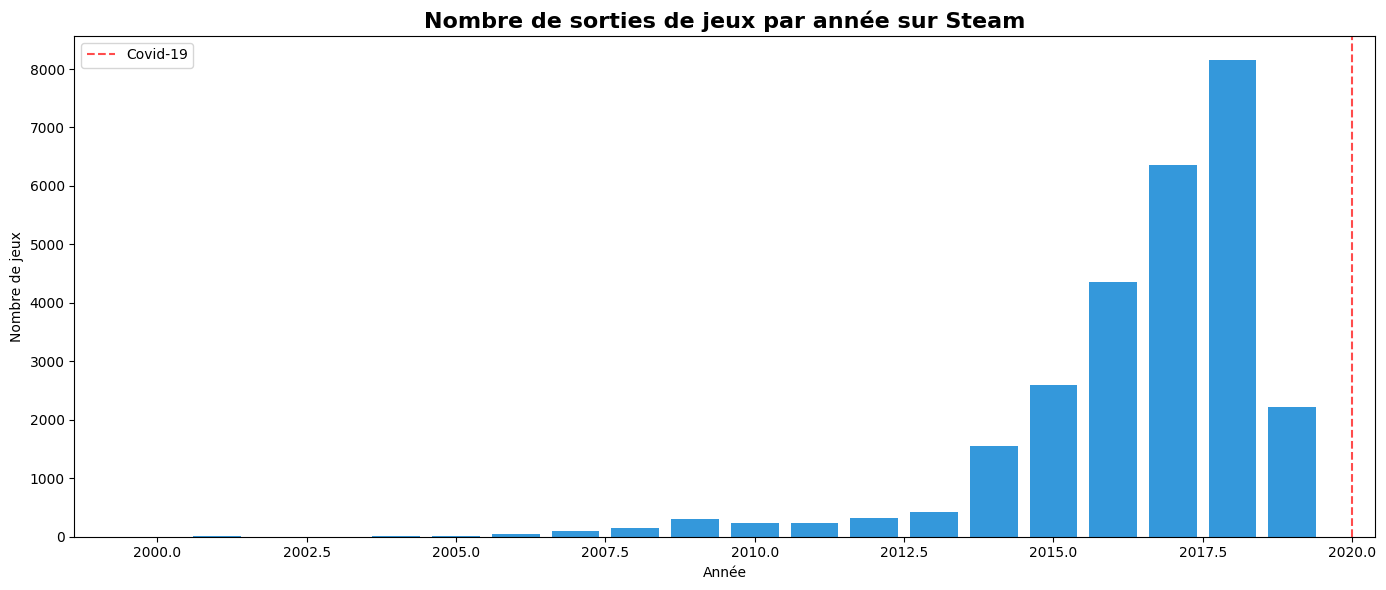

 Visualisation 1 OK


In [0]:
# ============================================================
# CELLULE 19 — VISUALISATION : Sorties par année
# ============================================================
import matplotlib.pyplot as plt
import pandas as pd

# Convertir en pandas pour visualisation
sorties_pd = df.filter(col("year").isNotNull()) \
    .filter(col("year") >= 2000) \
    .groupBy("year") \
    .agg(count("appid").alias("nb_sorties")) \
    .orderBy("year") \
    .toPandas()

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(sorties_pd["year"], sorties_pd["nb_sorties"], 
              color=["#e74c3c" if y >= 2020 else "#3498db" for y in sorties_pd["year"]])
ax.set_title("Nombre de sorties de jeux par année sur Steam", fontsize=16, fontweight="bold")
ax.set_xlabel("Année")
ax.set_ylabel("Nombre de jeux")
ax.axvline(x=2020, color="red", linestyle="--", alpha=0.7, label="Covid-19")
ax.legend()
plt.tight_layout()
plt.savefig("/tmp/sorties_annee.png", dpi=150)
plt.show()
print(" Visualisation 1 OK")

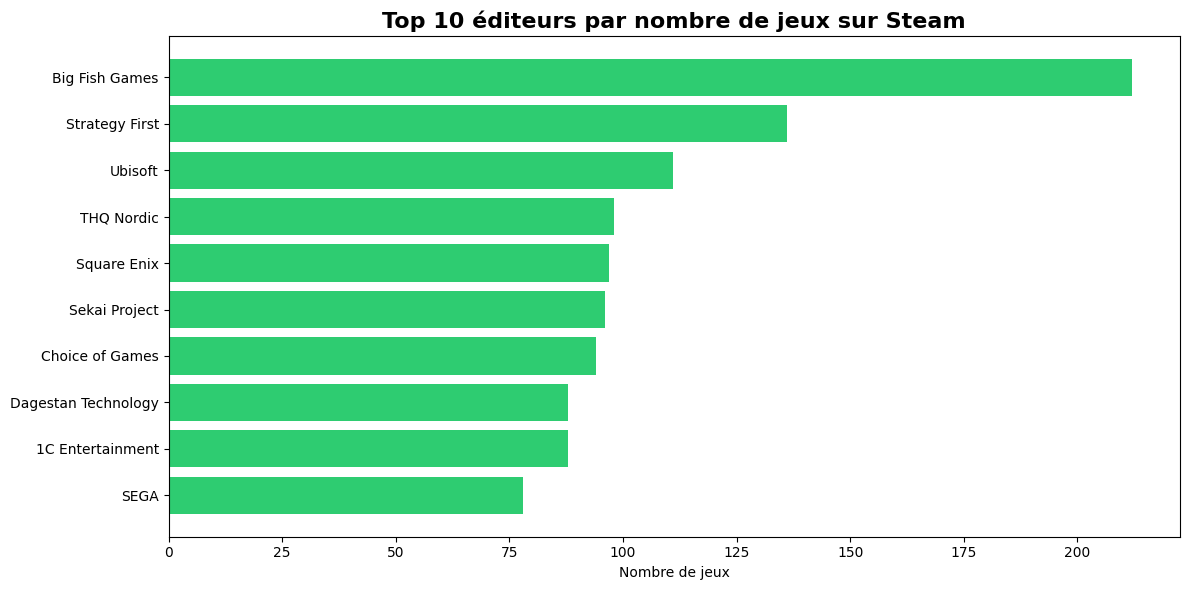

 Visualisation 2 OK


In [0]:
# ============================================================
# CELLULE 20 — VISUALISATION : Top éditeurs
# ============================================================
top_pub_pd = df.groupBy("publisher") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .limit(10) \
    .toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_pub_pd["publisher"][::-1], top_pub_pd["nb_jeux"][::-1], color="#2ecc71")
ax.set_title("Top 10 éditeurs par nombre de jeux sur Steam", fontsize=16, fontweight="bold")
ax.set_xlabel("Nombre de jeux")
plt.tight_layout()
plt.savefig("/tmp/top_editeurs.png", dpi=150)
plt.show()
print(" Visualisation 2 OK")

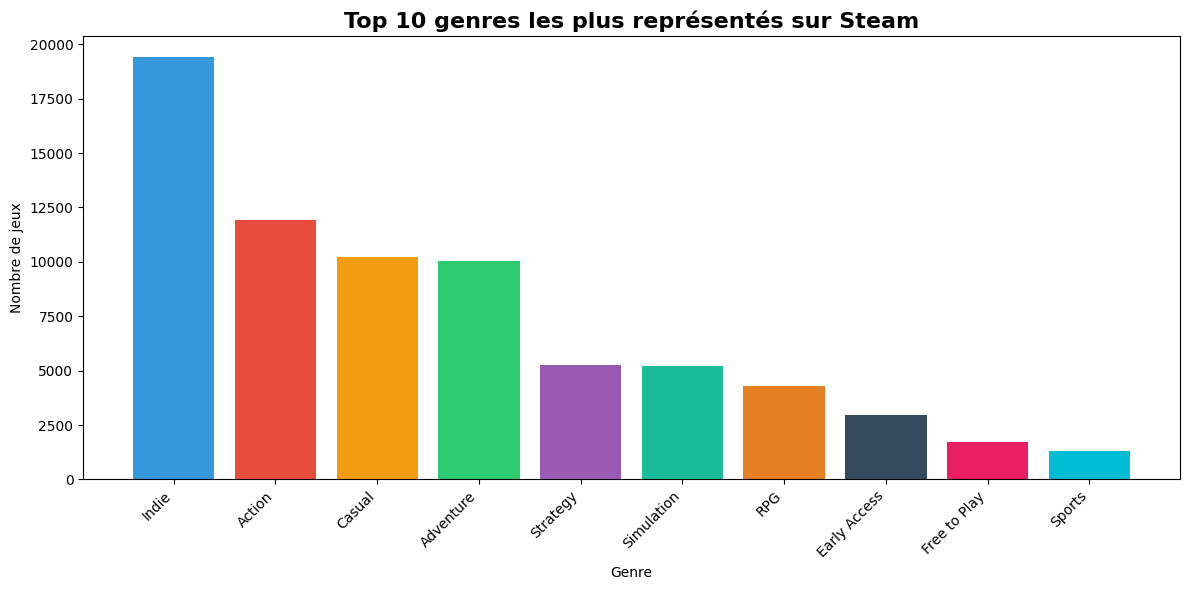

 Visualisation 3 OK


In [0]:
# ============================================================
# CELLULE 21 — VISUALISATION : Top genres
# ============================================================
genres_pd = df_genres.groupBy("genre") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .limit(10) \
    .toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#3498db", "#e74c3c", "#f39c12", "#2ecc71", "#9b59b6",
          "#1abc9c", "#e67e22", "#34495e", "#e91e63", "#00bcd4"]
ax.bar(genres_pd["genre"], genres_pd["nb_jeux"], color=colors)
ax.set_title("Top 10 genres les plus représentés sur Steam", fontsize=16, fontweight="bold")
ax.set_xlabel("Genre")
ax.set_ylabel("Nombre de jeux")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/tmp/top_genres.png", dpi=150)
plt.show()
print(" Visualisation 3 OK")

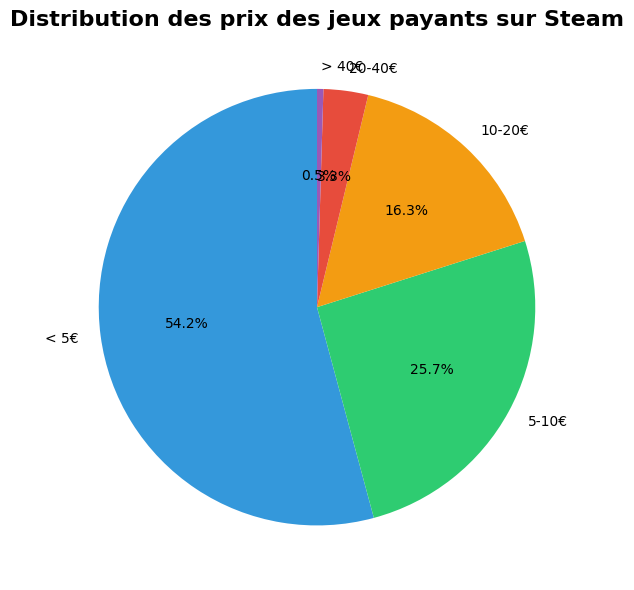

 Visualisation 4 OK


In [0]:
# ============================================================
# CELLULE 22 — VISUALISATION : Distribution des prix
# ============================================================
prix_pd = df.filter(col("price") > 0) \
    .withColumn("tranche_prix",
        when(col("price") < 5, "< 5€")
        .when(col("price") < 10, "5-10€")
        .when(col("price") < 20, "10-20€")
        .when(col("price") < 40, "20-40€")
        .otherwise("> 40€")
    ) \
    .groupBy("tranche_prix") \
    .agg(count("appid").alias("nb_jeux")) \
    .toPandas()

ordre = ["< 5€", "5-10€", "10-20€", "20-40€", "> 40€"]
prix_pd["tranche_prix"] = pd.Categorical(prix_pd["tranche_prix"], categories=ordre, ordered=True)
prix_pd = prix_pd.sort_values("tranche_prix")

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(prix_pd["nb_jeux"], labels=prix_pd["tranche_prix"], autopct="%1.1f%%",
       colors=["#3498db", "#2ecc71", "#f39c12", "#e74c3c", "#9b59b6"],
       startangle=90)
ax.set_title("Distribution des prix des jeux payants sur Steam", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("/tmp/distribution_prix.png", dpi=150)
plt.show()
print(" Visualisation 4 OK")

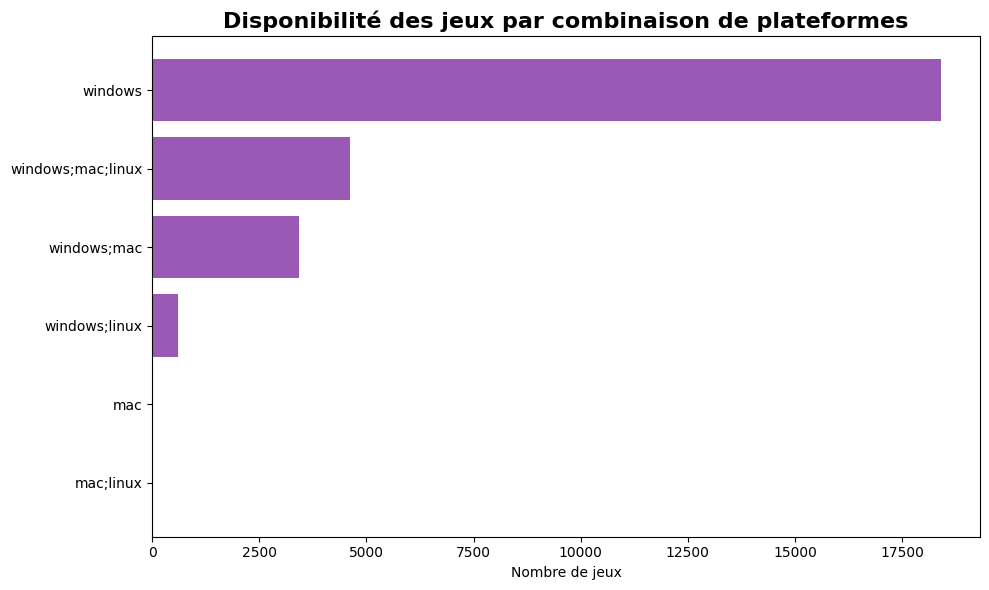

 Visualisation 5 OK


In [0]:
# ============================================================
# CELLULE 23 — VISUALISATION : Plateformes
# ============================================================
platforms_pd = df.groupBy("platforms") \
    .agg(count("appid").alias("nb_jeux")) \
    .orderBy(desc("nb_jeux")) \
    .limit(6) \
    .toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(platforms_pd["platforms"][::-1], platforms_pd["nb_jeux"][::-1], color="#9b59b6")
ax.set_title("Disponibilité des jeux par combinaison de plateformes", fontsize=16, fontweight="bold")
ax.set_xlabel("Nombre de jeux")
plt.tight_layout()
plt.savefig("/tmp/plateformes.png", dpi=150)
plt.show()
print(" Visualisation 5 OK")